## Load File

In [3]:
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import imageio
import os
from tqdm import tqdm  # For progress bars

filename = 'multiple_waves2.nc' #remember.nc at the end
ds = xr.open_dataset(filename, engine = 'netcdf4', decode_times=False)


# Non-dimensionalising timescale
g = 9.81
f = 1e-4
L = 10*1000
H_front = 100

# Rescale time: convert seconds to non-dimensional time = f * t
# Ensure 'time' is in seconds (if it's in days, convert to seconds first)
time = ds.time.values
nondim_time =  time * f 


# Add non-dimensional time to dataset for convenience
ds = ds.assign_coords(nondim_time=("time", nondim_time))



In [82]:
ds.b

<xarray.DataArray 'b' (time: 21, z_aac: 160, x_caa: 500)> Size: 7MB
[1680000 values with dtype=float32]
Coordinates:
  * time         (time) float64 168B 0.0 600.0 1.2e+03 ... 1.14e+04 1.2e+04
  * x_caa        (x_caa) float32 2kB -4.99e+03 -4.97e+03 ... 4.97e+03 4.99e+03
  * z_aac        (z_aac) float32 640B -99.69 -99.06 -98.44 ... -0.9375 -0.3125
    nondim_time  (time) float64 168B 0.0 0.06 0.12 0.18 ... 1.02 1.08 1.14 1.2
Attributes:
    units:      m/s²
    long_name:  Buoyancy

## Buoyancy Animation

In [4]:
# contours working

b = ds['b'].load()  # Load only after preprocessing

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(b.quantile(0.05)), float(b.quantile(0.95))
x_km = ds.x_caa.values / 1e3 
#x_nondim = ds.x_caa.values / L

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    b_data = b.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, b_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(pc, ax=ax, label='Buoyancy (m/s²)')  
    
    
    
    ax.contour(x_km, ds.z_aac.values, b_data, 
              levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, Buoyancy plot",
           xlabel="x (non dim) ", ylabel="z (m)")
    #ax.axvline(-x_km.max() + 4 , color='0.5', linestyle='--')
    #ax.axvline(x_km.max() - 4, color='0.5', linestyle='--')
    
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_buoyancy.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

0it [00:00, ?it/s]


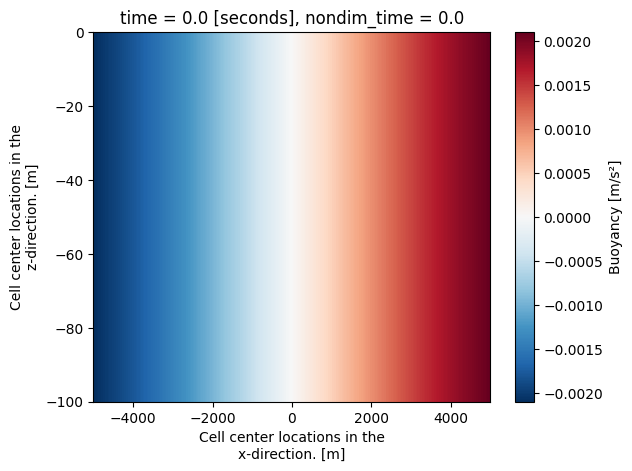

In [57]:
ds.b[0,:,:].plot()

## Frontogenesis Visualisation (M^2)

In [ ]:
# contours working

b = ds['b'].load()  # Load only after preprocessing
M_squared = ds['M_squared'].load()


# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(M_squared.quantile(0.05)), float(M_squared.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    b_data = b.isel(time=i).values
    M_squared_data = M_squared.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, M_squared_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(pc, ax=ax, label='M_squared or db/dx')  
    
    
    
    #ax.contour(x_km, ds.z_aac.values, b_data, 
              #levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, M_squared plot",
           xlabel="x (km)", ylabel="z (m)")
    #ax.axvline(-x_km.max() + 4 , color='0.5', linestyle='--')
    #ax.axvline(x_km.max() - 4, color='0.5', linestyle='--')
    
    
    ax.set_xlim(-100, 100)
    
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_buoyancy.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 54/54 [00:13<00:00,  3.94it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_5828\4017835063.py:54: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1001, 586) to (1008, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


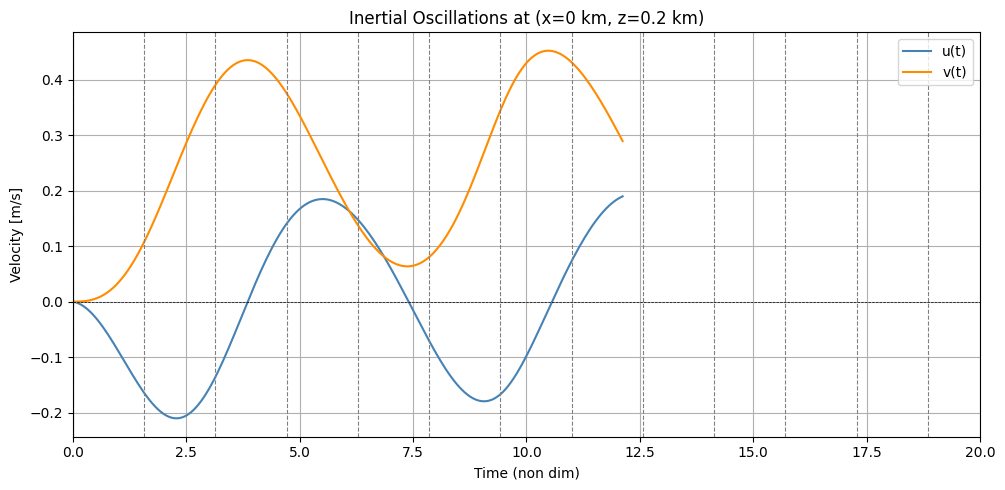

In [26]:
# === Choose fixed (x, z) location ===
x_target = 0       # center of the front
z_target = -ds.z_aac.values.max() / 2  # mid-depth

# === Find nearest grid indices ===
x_index = np.argmin(np.abs(ds.x_caa.values - x_target))
z_index = np.argmin(np.abs(ds.z_aac.values - z_target))


# === Extract time series ===
time = ds.time.values # convert from nanoseconds to hours (if needed)
u_t = ds.u[:, z_index, x_index].values
v_t = ds.v[:, z_index, x_index].values
w_t = ds.w[:, z_index, x_index].values

# === Plot ===
plt.figure(figsize=(10, 5))
plt.plot(nondim_time, u_t, label='u(t)', color='steelblue')
plt.plot(nondim_time, v_t, label='v(t)', color='darkorange')
#plt.plot(nondim_time, w_t, label='v(t)', color='darkred')
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.title(f'Inertial Oscillations at (x={x_target} km, z={z_target:.1f} km)')
plt.xlabel('Time (non dim)')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0,20)

for t in range(0,20):
    plt.axvline(x= t*np.pi/2, color='gray', linestyle='--', linewidth=0.8)
    #plt.text(t, 0, f'{t}π/2', ha='center', va='top', fontsize=10, rotation=90)
plt.show()



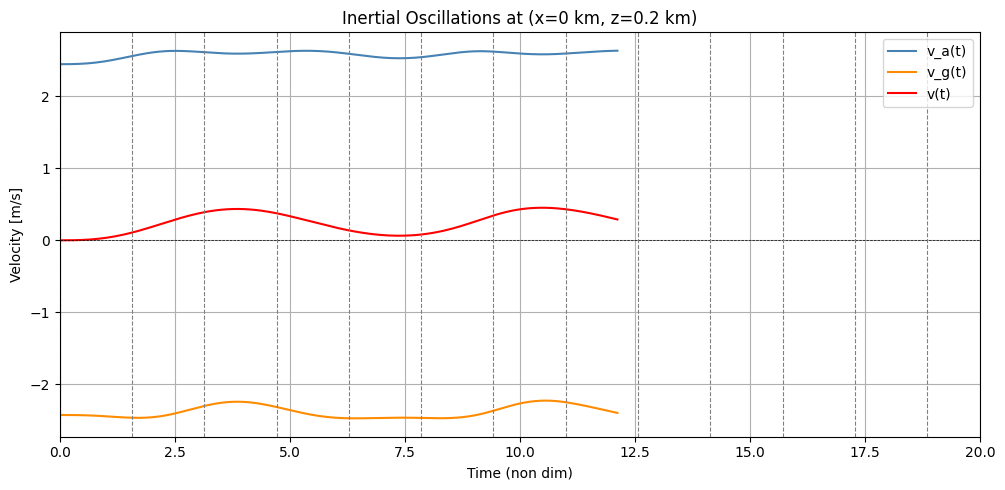

In [35]:
plt.close()
# === Choose fixed (x, z) location ===
x_target = 0      # center of the front
z_target = -ds.z_aac.values.max() / 2  # mid-depth

# === Find nearest grid indices ===
x_index = np.argmin(np.abs(ds.x_caa.values - x_target))
z_index = np.argmin(np.abs(ds.z_aac.values - z_target))


# === Extract time series ===
time = ds.time.values # convert from nanoseconds to hours (if needed)
v_a_t = ds.v_a[:, z_index, x_index].values
v_g_t = ds.v_g[:, z_index, x_index].values
v_t = ds.v[:, z_index, x_index].values

# === Plot ===
plt.figure(figsize=(10, 5))
plt.plot(nondim_time, v_a_t, label='v_a(t)', color='steelblue')
plt.plot(nondim_time, v_g_t, label='v_g(t)', color='darkorange')
plt.plot(nondim_time, v_t, label='v(t)', color='red')
#plt.plot(nondim_time, w_t, label='v(t)', color='darkred')
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.title(f'Inertial Oscillations at (x={x_target} km, z={z_target:.1f} km)')
plt.xlabel('Time (non dim)')
plt.ylabel('Velocity [m/s]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(0,20)

for t in range(0,20):
    plt.axvline(x= t*np.pi/2, color='gray', linestyle='--', linewidth=0.8)
    #plt.text(t, 0, f'{t}π/2', ha='center', va='top', fontsize=10, rotation=90)
plt.show()



## Geostrophic and ageostrophic flow

In [36]:
# Allocate v_g with same shape as dbdX

v_g = -(g / f) * ds.dbdX * (H_front / 2 - ds.z_aac)

#v_a = ds.v - v_g
v_g = -(g / f) * ds.dbdX * (H_front / 2 - ds.z_aac)
ds["v_g"] = v_g

v_g_on_center = ds.v_g.interp(x_faa=ds.x_caa)

v_g_on_center

v_a = ds.v - v_g_on_center

ds["v_a"] = v_a

ds


<xarray.Dataset> Size: 586MB
Dimensions:      (x_caa: 500, x_faa: 501, z_aac: 160, z_aaf: 161, time: 203)
Coordinates:
  * time         (time) float64 2kB 0.0 600.0 1.2e+03 ... 1.206e+05 1.212e+05
  * x_faa        (x_faa) float32 2kB -3.2e+05 -3.187e+05 ... 3.187e+05 3.2e+05
  * x_caa        (x_caa) float32 2kB -3.194e+05 -3.181e+05 ... 3.194e+05
  * z_aaf        (z_aaf) float32 644B -100.0 -99.38 -98.75 ... -1.25 -0.625 0.0
  * z_aac        (z_aac) float32 640B -99.69 -99.06 -98.44 ... -0.9375 -0.3125
    nondim_time  (time) float64 2kB 0.0 0.06 0.12 0.18 ... 12.0 12.06 12.12
Data variables: (12/13)
    Δx_caa       (x_caa) float32 2kB ...
    Δx_faa       (x_faa) float32 2kB ...
    Δz_aac       (z_aac) float32 640B ...
    Δz_aaf       (z_aaf) float32 644B ...
    M_squared    (time, z_aac, x_faa) float32 65MB ...
    Ri           (time, z_aaf, x_faa) float32 65MB ...
    ...           ...
    dbdX         (time, z_aac, x_faa) float32 65MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    u            (time, z_aac, x_faa) float32 65MB ...
    v            (time, z_aac, x_caa) float32 65MB ...
    w            (time, z_aaf, x_caa) float32 65MB ...
    v_g          (time, z_aac, x_faa) float32 65MB -0.0 -0.0 -0.0 ... -0.0 -0.0
    v_a          (time, z_aac, x_caa) float32 65MB 0.0 0.0 ... -6.632e-20
Attributes:
    Julia:                 This file was generated using Julia Version 1.11.5...
    Oceananigans:          This file was generated using Oceananigans v0.96.35
    date:                  This file was generated on 2025-07-28T12:16:33.094...
    interval:              600.0
    output time interval:  Output was saved every 10 minutes.
    schedule:              TimeInterval

## geostrophic velocity plot

In [23]:
# contours working

b = ds['b'].load()  # Load only after preprocessing


# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(v_g.quantile(0.05)), float(v_g.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    b_data = b.isel(time=i).values
    v_g_data = v_g.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, v_g_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(pc, ax=ax, label='M_squared or db/dx')  
    
    
    
    #ax.contour(x_km, ds.z_aac.values, b_data, 
              #levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, v_g plot",
           xlabel="x (km)", ylabel="z (m)")
    #ax.axvline(-x_km.max() + 4 , color='0.5', linestyle='--')
    #ax.axvline(x_km.max() - 4, color='0.5', linestyle='--')
    
    
    ax.set_xlim(-100, 100)
    
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_geostrophic_v.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 102/102 [00:27<00:00,  3.76it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_5124\3403128349.py:53: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1038, 586) to (1040, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Ageostrophic velocity plot

  0%|          | 0/102 [00:00<?, ?it/s]


TypeError: Length of x (501) must match number of columns in z (500)

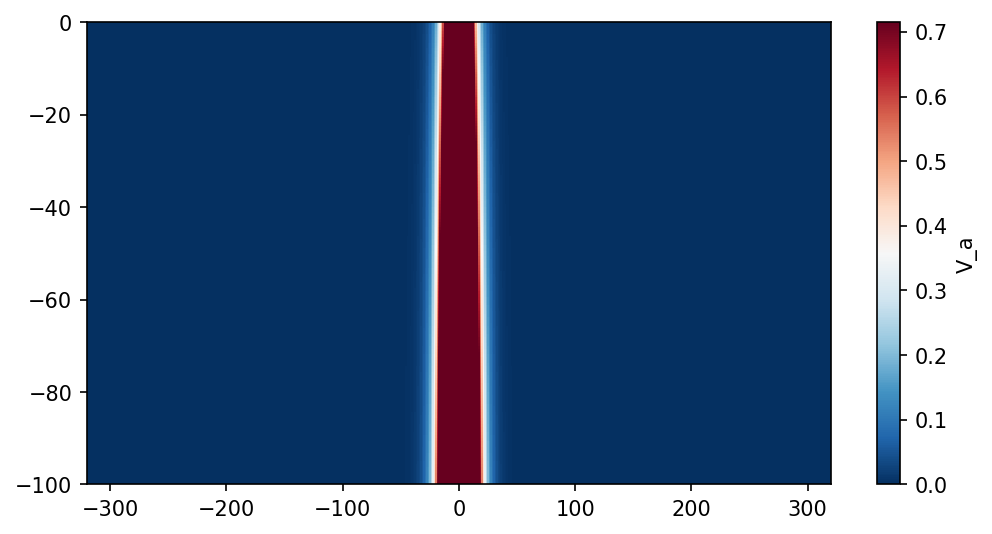

In [14]:
# contours working

b = ds['b'].load()  # Load only after preprocessing


# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(v_a.quantile(0.05)), float(v_a.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    b_data = b.isel(time=i).values
    v_a_data = v_a.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aaf.values, v_a_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(pc, ax=ax, label='V_a')  
    
    
    
    ax.contour(x_km, ds.z_aaf.values, b_data, 
              levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, v_a plot",
           xlabel="x (km)", ylabel="z (m)")
    #ax.axvline(-x_km.max() + 4 , color='0.5', linestyle='--')
    #ax.axvline(x_km.max() - 4, color='0.5', linestyle='--')
    
    
    ax.set_xlim(-100, 100)
    
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_geostrophic_a.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

## Richardson number

In [48]:
Ri = ds['Ri'].load()  # Load only after preprocessing

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(b.quantile(0.05)), float(b.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    Ri_data = Ri.isel(time=i).values
    b_data = b.isel(time=i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aaf.values, Ri_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(pc, ax=ax, label='Ri')  
    
    
    
    #ax.contour(x_km, ds.z_aaf.values, b_data, 
              #levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, Ri number plot",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 4 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 4, color='0.5', linestyle='--')
    
    #ax.set_xlim(-1,1)
    
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_Ri.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)


100%|██████████| 102/102 [00:24<00:00,  4.08it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_11492\1285258174.py:49: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1046, 586) to (1056, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [ ]:
ds.Ri.shape


(21, 100, 500, 501)

## Along fron velocity (u)

In [ ]:
# contours not working

u = ds['u'].load()  # Load only after preprocessing
b = ds['b'].load()

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(u.quantile(0.05)), float(u.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    u_data = u.isel(time=i).values
    b_data = b.isel(time =i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aac.values, u_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    #ax.contour(x_km, ds.z_aaf.values, b_data, 
          #  levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, Buoyancy plot",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 2* x_km.max()/10 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 2*x_km.max()/10, color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_u.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 52/52 [00:26<00:00,  1.98it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_30368\2593955291.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1060, 586) to (1072, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Along jet velocity (v)

In [ ]:
# contours not working

v = ds['v'].load()  # Load only after preprocessing
b = ds['b'].load()

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(v.quantile(0.05)), float(v.quantile(0.95))
x_km = ds.x_faa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    v_data = v.isel(time=i).values
    b_data = b.isel(time =i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aaf.values, v_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    #ax.contour(x_km, ds.z_aaf.values, b_data, 
          #  levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, along jet (v)",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 2* x_km.max()/10 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 2*x_km.max()/10, color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_v.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 52/52 [00:29<00:00,  1.79it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_30368\3530609042.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1060, 586) to (1072, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Vertical velocity (w)

In [ ]:
# contours not working

w = ds['w'].load()  # Load only after preprocessing
b = ds['b'].load()

# 2. Downsample in Time (every 10th frame)
time_step = max(1, len(ds.time)//100)  # Target ~100 frames max
selected_times = ds.time[::time_step]

# 3. Pre-compute plot limits
vmin, vmax = float(w.quantile(0.05)), float(w.quantile(0.95))
x_km = ds.x_caa.values / 1e3 

# 4. Parallel Frame Generation (faster than sequential)
def create_frame(i):
    fig, ax = plt.subplots(figsize=(8,4), dpi=150)
    w_data = w.isel(time=i).values
    b_data = b.isel(time =i).values
    
    # Optimized plotting
    pc = ax.pcolormesh(x_km, ds.z_aaf.values, w_data, 
                      cmap='RdBu_r', shading='auto',
                      vmin=vmin, vmax=vmax)
    
    ax.contour(x_km, ds.z_aac.values, b_data, 
            levels=10, colors='k', linewidths=0.5)
    
    ax.set(title=f"t = {ds.time.nondim_time[i].values:.2f}, {filename}, vertical (w)",
           xlabel="x (km)", ylabel="z (m)")
    ax.axvline(-x_km.max() + 2* x_km.max()/10 , color='0.5', linestyle='--')
    ax.axvline(x_km.max() - 2*x_km.max()/10, color='0.5', linestyle='--')
    
    frame_path = f"frames/frame_{i:04d}.png"
    fig.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)
    return frame_path

# 5. Process frames in batches
frame_paths = []
for i in tqdm(range(0, len(ds.time), time_step)):
    frame_paths.append(create_frame(i))

# 6. Faster video compilation
imageio.mimsave(f"{filename}_w.mp4", 
               [imageio.imread(fp) for fp in frame_paths],
               fps=10,  # Increased frames per second
               codec='libx264', 
               quality=8)

# Cleanup
for fp in frame_paths:
    os.remove(fp)

100%|██████████| 102/102 [00:57<00:00,  1.78it/s]
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_30368\692373657.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  [imageio.imread(fp) for fp in frame_paths],
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1060, 586) to (1072, 592) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## Blumen theory plots

TypeError: Input z must be 2D, not 0D

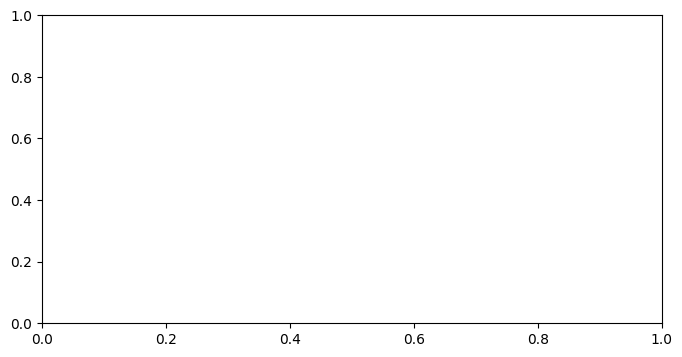

In [35]:
# Domain and parameters
Ro = 1/2 # Rossby number (try 0.9 for smooth, >1 for blow-up)
M_squared = (Ro**2 * f**2 *L)/H_front
delta_b = M_squared*L
t = np.pi / 2         # Time (try np.linspace(0, 2*np.pi, ...) to animate)
nx, nz = 200, 100     # Grid resolution

# Grids
x = np.linspace(-np.pi, np.pi, nx)
z = np.linspace(0, 1, nz)
X, Z = np.meshgrid(x, z)

# Theoretical solution for vertical velocity w*
def v(x, z, t):
    return -g/f * delta_b/2 * np.cos(x) * (50 - z) * (1 - np.cos(f*t))

#so at x = 0, z = 0

v = v(0, 0, t)

# Plot
plt.figure(figsize=(8, 4))
cp = plt.contourf(x, z, v, levels=30, cmap='RdBu_r')
plt.colorbar(cp, label='$w^*(x, z, t)$')
plt.title(f'Blumen 2000 Theoretical $w^*$ at $t={t:.2f}$')
plt.xlabel('$x$')
plt.ylabel('$z$')
plt.tight_layout()
plt.show()


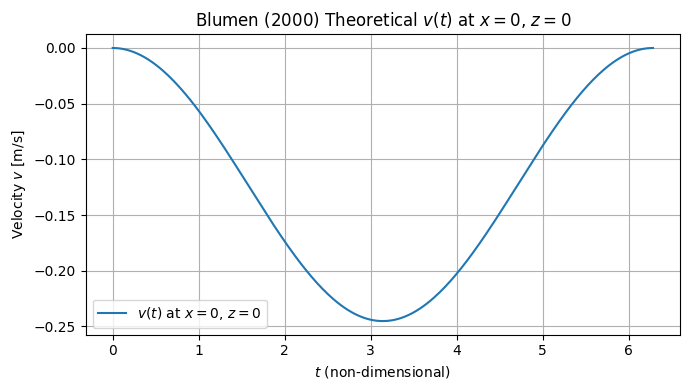

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants
f = 1e-4          # Coriolis parameter [s^-1]
g = 9.81          # Gravity [m/s^2]
L = 1000          # Horizontal scale [m]
H_front = 100     # Vertical scale [m]

# Rossby number
Ro = 1/2
M_squared = (Ro**2 * f**2 * L) / H_front   # Horizontal buoyancy gradient
delta_b = M_squared * L                   # Total buoyancy difference

# Time array (one inertial period)
t = np.linspace(0, 2*np.pi, 300)

# Theoretical solution for v(x=0, z=0, t)
x = 0
z = 0

v_t = -g/f * delta_b/L * np.cos(x) * (H_front/2 - z) * (1 - np.cos(t))

# Plot
plt.figure(figsize=(7, 4))
plt.plot(t, v_t, label='$v(t)$ at $x=0$, $z=0$')
plt.xlabel('$t$ (non-dimensional)')
plt.ylabel('Velocity $v$ [m/s]')
plt.title('Blumen (2000) Theoretical $v(t)$ at $x=0$, $z=0$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

